In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 12.0 MB/s 
     |████████████████████████████████| 7.6 MB 53.1 MB/s 
     |████████████████████████████████| 182 kB 52.6 MB/s 


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/ECE1786/Project")

In [ ]:
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [ ]:
train_df = pd.read_csv('data/train.tsv', sep='\t', index_col=0)
validation_df = pd.read_csv('data/validation.tsv', sep='\t', index_col=0)
test_df = pd.read_csv('data/test.tsv', sep='\t', index_col=0)

In [ ]:
train_df

,tweet,class
23140,jersey fam breakfast almost ready,2
28381,any more birds school,2
26950,why mcdonald breakfast good but the lunch trash,2
13083,all the hoes loveandhiphop going prom,1
14164,drink pussy juice nigga,1
...,...,...
16588,baby momma bitch wife like pac need thug life,1
14071,these hoes not loyal,1
28713,going work sho relative named mark now everyone,2
8040,some drunk irish nigga yelled build that wall ...,0


In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Dataset creator for Pytorch
class DatasetCreator(Dataset):
    def __init__(self, processed_data, train):
        self.data = processed_data
        self.train = train
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        line = self.data.iloc[index]
        if self.train:
            return {'text': line['tweet'], 'label': line['class']}
        else:
            return {'text': line['tweet'], 'label': 0}

In [ ]:
# Class to tokenize and process the text for input to the dataloader    
class GPT2_collator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})       
        return inputs

In [ ]:
# Function for training
def train(dataloader, optimizer, scheduler, device):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

In [ ]:
# Function for validation 
def validate(dataloader, device):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            total_loss += loss.item()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

In [ ]:
def predict(dataloader, device):
    global model
    model.eval()
    predictions_labels = []
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            _, logits = outputs[:2]
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    return predictions_labels 

# Load the model

In [ ]:
# Define the model parameters
max_len = None # Max lenght of the text for input
batch_size = 32
epochs = 15

In [ ]:
print('Loading gpt-2 model')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=3)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=model_config)
model.resize_token_embeddings(len(tokenizer)) 
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

Loading gpt-2 model


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

# Create the dataloader

In [ ]:
gpt2_collator = GPT2_collator(tokenizer=tokenizer, max_seq_len=max_len)

# Dataloader for training data
train_data = DatasetCreator(train_df, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

# Dataloader for validation data
val_data = DatasetCreator(validation_df, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

In [ ]:
train_dataloader

In [ ]:
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8, weight_decay=0.01)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
loss = []
accuracy = []
val_loss_list = []
val_accuracy_list = []

for epoch in tqdm(range(epochs)):
    train_labels, true_labels, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(true_labels, train_labels) 
    # print('epoch: %.2f train accuracy %.2f' % (epoch, train_acc))
    loss.append(train_loss)
    accuracy.append(train_acc)

    val_labels, val_true_labels, val_loss = validate(val_dataloader, device)
    val_acc= accuracy_score(val_true_labels, val_labels)
    # print('epoch: %.2f validation accuracy %.2f' % (epoch, val_acc))
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

    print(' Epoch {} \ttraining loss={:.7f} \tvalidation loss={:.7f}'.format(epoch+1,train_loss, val_loss))
    print(' \t\ttraining accuracy={:.2f}% \tvalidation accuracy={:.2f}%'.format(train_acc*100, val_acc*100))

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 1 	training loss=0.6764005 	validation loss=0.5202949
 		training accuracy=71.04% 	validation accuracy=80.35%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 2 	training loss=0.4877539 	validation loss=0.4596878
 		training accuracy=81.33% 	validation accuracy=82.83%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 3 	training loss=0.4469020 	validation loss=0.4647463
 		training accuracy=82.87% 	validation accuracy=83.33%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 4 	training loss=0.4562801 	validation loss=0.4885254
 		training accuracy=82.66% 	validation accuracy=82.02%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 5 	training loss=0.4368387 	validation loss=0.4584336
 		training accuracy=83.16% 	validation accuracy=83.02%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 6 	training loss=0.4163373 	validation loss=0.4700069
 		training accuracy=84.09% 	validation accuracy=82.73%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 7 	training loss=0.4158000 	validation loss=0.4642825
 		training accuracy=84.31% 	validation accuracy=82.73%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 8 	training loss=0.4535388 	validation loss=0.4690468
 		training accuracy=83.10% 	validation accuracy=82.71%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 9 	training loss=0.4146455 	validation loss=0.4652150
 		training accuracy=84.32% 	validation accuracy=83.08%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 10 	training loss=0.4225891 	validation loss=0.5042399
 		training accuracy=83.90% 	validation accuracy=81.29%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 11 	training loss=0.4054860 	validation loss=0.4861588
 		training accuracy=84.77% 	validation accuracy=82.79%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 12 	training loss=0.4051916 	validation loss=0.4730208
 		training accuracy=84.25% 	validation accuracy=82.54%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 13 	training loss=0.3956711 	validation loss=0.4615518
 		training accuracy=84.61% 	validation accuracy=83.29%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 14 	training loss=0.3920678 	validation loss=0.4635256
 		training accuracy=84.92% 	validation accuracy=83.73%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 15 	training loss=0.3864430 	validation loss=0.4547195
 		training accuracy=85.16% 	validation accuracy=83.42%


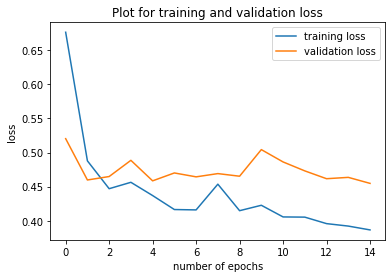

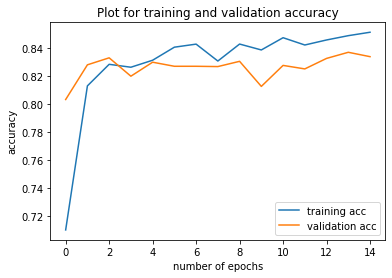

In [ ]:
fig = plt.figure()
plt.plot(range(0, len(loss)), loss, label ='training loss')
plt.plot(range(0, len(val_loss_list)), val_loss_list, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(0, len(accuracy)), accuracy, label ='training acc')
plt.plot(range(0, len(val_accuracy_list)), val_accuracy_list, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()